In [7]:
import pandas as pd 
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
import numpy as np
import warnings
warnings.simplefilter(action='ignore')

In [8]:
# ETF1:國內成分證券 ETF
etf1_list = ["VTI","IWB","SOXX","XLI","XLY","VIOV","XLE","DIA","VOX","XLP","XLK","XLF","QQQ","VOO"]
# ETF2:國外成分證券 ETF(股票)
etf2_list = ['VXUS','ACWX','SCHF','IDV','VEU']
# ETF3:境外 ETF
etf3_list = []
# ETF4:槓桿行 ETF
etf4_list = ['SOXL','TQQQ','UPRO','FAS','SSO']
# ETF5:反向行 ETF
etf5_list = ['PSQ','SOXS','SH','SQQQ','SDS']
# ETF6:原型期貨
etf6_list = ['USO','GLD']
# ETF7:槓桿型期貨 ETF
etf7_list = ['UCO']
# ETF8:反向型期貨 ETF 
etf8_list = ['SCO']
# ETF9:國外成分證券 ETF(證券)
etf9_list = ['IGOV','BNDX','IBND','BGRN','VWOB']



etf_list = {
    "ETF1" : ["VTI","IWB","SOXX","XLI","XLY","VIOV","XLE","DIA","VOX","XLP","XLK","XLF","QQQ","VOO"],
    "ETF2" : ['VXUS','ACWX','SCHF','IDV','VEU'],
    "ETF3" : [],
    "ETF4" : ['SOXL','TQQQ','UPRO','FAS','SSO'],
    "ETF5" : ['PSQ','SOXS','SH','SQQQ','SDS'],
    "ETF6" : ['USO','GLD'],
    "ETF7" : ['UCO'],
    "ETF8" : ['SCO'],
    "ETF9" : ['IGOV','BNDX','IBND','BGRN','VWOB']
}

In [9]:

etfs = etf1_list+etf2_list+etf3_list+etf4_list+etf5_list+etf6_list+etf7_list+etf8_list+etf9_list


In [10]:

def get_data_from_yfinance(pool: list, start, end) -> pd.DataFrame:
    df = yf.download(pool, start=start, end=end, ignore_tz=True, progress=False)
    Adj_rate = df['Adj Close']/df['Close']
    for column in ['Close', 'Open', 'High', 'Low']:
        df[column] *= Adj_rate
        df[column] = df[column].ffill()  # fill forward 
    return df.loc[:, (slice(None), pool)]['Close']

def count_return(df_etfs,etf_list):
    df_etf = df_etfs[df_etfs.columns.intersection(etf_list)]
    df_etf['equal_weight_sum'] = df_etf.sum(axis=1)
    for etf in df_etf.columns:
        df_etf[str(etf)+'weight'] = df_etf[str(etf)]**2/df_etf['equal_weight_sum']
    df_etf['value_weight_sum'] =df_etf.iloc[:,(len(etf_list)+1):].sum(axis=1)
    df_etf['d_ew_return'] = df_etf['equal_weight_sum'].pct_change()
    df_etf['w_ew_return'] = df_etf['equal_weight_sum'].pct_change(periods=5)
    df_etf['m_ew_return'] = df_etf['equal_weight_sum'].pct_change(periods=20)
    df_etf['q_ew_return'] = df_etf['equal_weight_sum'].pct_change(periods=60)
    df_etf['d_vw_return'] = df_etf['value_weight_sum'].pct_change()
    df_etf['w_vw_return'] = df_etf['value_weight_sum'].pct_change(periods=5)
    df_etf['m_vw_return'] = df_etf['value_weight_sum'].pct_change(periods=20)
    df_etf['q_vw_return'] = df_etf['value_weight_sum'].pct_change(periods=60)
    df_etf.dropna(inplace=True)
    return df_etf

In [16]:

# ETF1:國內成分證券 ETF
def getNavSeries(df_now_for_nav, weighting, nav_current = 1, short=False):
    if short:
        df2 = (1 - df_now_for_nav.pct_change()).cumprod()
    else:

        df2 = (1 + df_now_for_nav.pct_change()).cumprod()
    # print(df2)
    df3 = df2.fillna(1)
    df4 = df3*nav_current
    nav_series = np.sum(df4 * weighting, axis=1)
    nav = nav_series.iloc[-1]
    return nav_series, nav

def subplots_x_y(total):
    x = np.sqrt(total)
    y = total/x
    if y == np.round(y):
        y = int(y)
    else:
        y = int(y) + 1
    if x == np.round(x):
        x = int(x) + 1
    else:
        x = int(x) + 1
    return x, y

def strategy(df_perf):
    buy_etf = df_perf['value_weight_mean'].idxmax()
    sell_etf = df_perf['value_weight_mean'].idxmin()
    return [buy_etf, sell_etf]


###

df_close 是 global variable 要改成可以設定期間

list_ 應該是根據df_close 還有前面所有公式得到的輪動，但現在是永遠都用2000-2024的df_close算出來的結果

只要

1. df_close 要可以算 2000 - 2006 / 2003 - 2009，但會有一大堆抓不到
2. 根據df_close 找出 list_, 用下面的東東就可以了

df_close => list_ 

下面兩個一個是用 2003 - 2024 的 df_close 算出來的list_, 一個是 2000 - 2024 的 df_close 算出來的 list_

In [ ]:
# jimmy
def get_quadrants_v2(start='2000-06-15', end='2024-05-06'):
    short_period = 60
    long_period = 250
    '''
    date = YYYY-MM-DD, 輸入查看象限當日
    '''
    # 大盤前三年累積報酬率(市場狀態)
    # twse_index = yf.download('^TWII',start="2000-06-15", end='2019-12-31')
    twse_index = yf.download('^SPX',start=start, end=end, progress=False)
    # print(len(twse_index[twse_index.index >= "2003-06-30"]))
    twse_index['Close_3y_b'] = twse_index['Close'].shift(long_period)
    twse_index['Close_1y_b'] = twse_index['Close'].shift(short_period)
    # twse_index['ret_3y'] = twse_index['Close']/twse_index['Close_3y_b'] - 1
    # twse_index['ret_1y'] = twse_index['Close']/twse_index['Close_1y_b'] - 1
    twse_index['pct_change'] = twse_index['Close'].pct_change()
    # twse_index['ret_cum_3y'] = (1+twse_index['pct_change']).rolling(window=750).agg(lambda x : x.prod()) -1
    twse_index['ret_3y'] = twse_index['pct_change'].rolling(long_period).sum()
    twse_index['ret_1y'] = twse_index['pct_change'].rolling(short_period).sum()
    twse_index['std_3y'] = twse_index['pct_change'].rolling(window=long_period).std()
    twse_index['std_1y'] = twse_index['pct_change'].rolling(window=short_period).std()
    twse_index['vol'] = twse_index['ret_1y'] - twse_index['ret_3y']
    # twse_index = twse_index[twse_index.index >= pd.to_datetime(start)+timedelta(days=365*3)]
    # print(len(twse_index))
    # twse_index.dropna(inplace=True)
    # 波動度
    cum_return_3Y = twse_index['ret_3y']
    volatility = twse_index['vol']
    
    quadrant = []

    for i in range(len(twse_index)):
        if cum_return_3Y[i]>0 and volatility[i]>0:
            quadrant.append(1)
        elif cum_return_3Y[i]<0 and volatility[i]>0:
            quadrant.append(2)
        elif cum_return_3Y[i]<0 and volatility[i]<0:
            quadrant.append(3)
        elif cum_return_3Y[i]>0 and volatility[i]<0:
            quadrant.append(4)
        else:
            quadrant.append(5)

    twse_index['signal'] = quadrant
    return twse_index


In [14]:
end = pd.to_datetime("2023-01-01")
start = end - timedelta(days=365*2)

# 2021股價, 計算 Nav
df_close = get_data_from_yfinance(etfs, start=end-timedelta(days=365), end=end+timedelta(days=365))

df_etfs = df_close.copy()
df_etf1 = count_return(df_etfs,etf1_list)
df_etf2 = count_return(df_etfs,etf2_list)
df_etf3 = count_return(df_etfs,etf3_list)
df_etf4 = count_return(df_etfs,etf4_list)
df_etf5 = count_return(df_etfs,etf5_list)
df_etf6 = count_return(df_etfs,etf6_list)
df_etf7 = count_return(df_etfs,etf7_list)
df_etf8 = count_return(df_etfs,etf8_list)
df_etf9 = count_return(df_etfs,etf9_list)

def get_performence(date_list,freq='d'):
    etf1_perf = [df_etf1[df_etf1.index.isin(date_list)][str(freq)+'_ew_return'].mean(),df_etf1[df_etf1.index.isin(date_list)][str(freq)+'_ew_return'].sem(),df_etf1[df_etf1.index.isin(date_list)][str(freq)+'_ew_return'].median(),
                df_etf1[df_etf1.index.isin(date_list)][str(freq)+'_vw_return'].mean(),df_etf1[df_etf1.index.isin(date_list)][str(freq)+'_vw_return'].sem(),df_etf1[df_etf1.index.isin(date_list)][str(freq)+'_vw_return'].median()]
    etf2_perf = [df_etf2[df_etf2.index.isin(date_list)][str(freq)+'_ew_return'].mean(),df_etf2[df_etf2.index.isin(date_list)][str(freq)+'_ew_return'].sem(),df_etf2[df_etf2.index.isin(date_list)][str(freq)+'_ew_return'].median(),
                df_etf2[df_etf2.index.isin(date_list)][str(freq)+'_vw_return'].mean(),df_etf2[df_etf2.index.isin(date_list)][str(freq)+'_vw_return'].sem(),df_etf2[df_etf2.index.isin(date_list)][str(freq)+'_vw_return'].median()]
    etf3_perf = [df_etf3[df_etf3.index.isin(date_list)][str(freq)+'_ew_return'].mean(),df_etf3[df_etf3.index.isin(date_list)][str(freq)+'_ew_return'].sem(),df_etf3[df_etf3.index.isin(date_list)][str(freq)+'_ew_return'].median(),
                df_etf3[df_etf3.index.isin(date_list)][str(freq)+'_vw_return'].mean(),df_etf3[df_etf3.index.isin(date_list)][str(freq)+'_vw_return'].sem(),df_etf3[df_etf3.index.isin(date_list)][str(freq)+'_vw_return'].median()]
    etf4_perf = [df_etf4[df_etf4.index.isin(date_list)][str(freq)+'_ew_return'].mean(),df_etf4[df_etf4.index.isin(date_list)][str(freq)+'_ew_return'].sem(),df_etf4[df_etf4.index.isin(date_list)][str(freq)+'_ew_return'].median(),
                df_etf4[df_etf4.index.isin(date_list)][str(freq)+'_vw_return'].mean(),df_etf4[df_etf4.index.isin(date_list)][str(freq)+'_vw_return'].sem(),df_etf4[df_etf4.index.isin(date_list)][str(freq)+'_vw_return'].median()]
    etf5_perf = [df_etf5[df_etf5.index.isin(date_list)][str(freq)+'_ew_return'].mean(),df_etf5[df_etf5.index.isin(date_list)][str(freq)+'_ew_return'].sem(),df_etf5[df_etf5.index.isin(date_list)][str(freq)+'_ew_return'].median(),
                df_etf5[df_etf5.index.isin(date_list)][str(freq)+'_vw_return'].mean(),df_etf5[df_etf5.index.isin(date_list)][str(freq)+'_vw_return'].sem(),df_etf5[df_etf5.index.isin(date_list)][str(freq)+'_vw_return'].median()]
    etf6_perf = [df_etf6[df_etf6.index.isin(date_list)][str(freq)+'_ew_return'].mean(),df_etf6[df_etf6.index.isin(date_list)][str(freq)+'_ew_return'].sem(),df_etf6[df_etf6.index.isin(date_list)][str(freq)+'_ew_return'].median(),
                df_etf6[df_etf6.index.isin(date_list)][str(freq)+'_vw_return'].mean(),df_etf6[df_etf6.index.isin(date_list)][str(freq)+'_vw_return'].sem(),df_etf6[df_etf6.index.isin(date_list)][str(freq)+'_vw_return'].median()]
    etf7_perf = [df_etf7[df_etf7.index.isin(date_list)][str(freq)+'_ew_return'].mean(),df_etf7[df_etf7.index.isin(date_list)][str(freq)+'_ew_return'].sem(),df_etf7[df_etf7.index.isin(date_list)][str(freq)+'_ew_return'].median(),
                df_etf7[df_etf7.index.isin(date_list)][str(freq)+'_vw_return'].mean(),df_etf7[df_etf7.index.isin(date_list)][str(freq)+'_vw_return'].sem(),df_etf7[df_etf7.index.isin(date_list)][str(freq)+'_vw_return'].median()]
    etf8_perf = [df_etf8[df_etf8.index.isin(date_list)][str(freq)+'_ew_return'].mean(),df_etf8[df_etf8.index.isin(date_list)][str(freq)+'_ew_return'].sem(),df_etf8[df_etf8.index.isin(date_list)][str(freq)+'_ew_return'].median(),
                df_etf8[df_etf8.index.isin(date_list)][str(freq)+'_vw_return'].mean(),df_etf8[df_etf8.index.isin(date_list)][str(freq)+'_vw_return'].sem(),df_etf8[df_etf8.index.isin(date_list)][str(freq)+'_vw_return'].median()]
    etf9_perf = [df_etf9[df_etf9.index.isin(date_list)][str(freq)+'_ew_return'].mean(),df_etf9[df_etf9.index.isin(date_list)][str(freq)+'_ew_return'].sem(),df_etf9[df_etf9.index.isin(date_list)][str(freq)+'_ew_return'].median(),
                df_etf9[df_etf9.index.isin(date_list)][str(freq)+'_vw_return'].mean(),df_etf9[df_etf9.index.isin(date_list)][str(freq)+'_vw_return'].sem(),df_etf9[df_etf9.index.isin(date_list)][str(freq)+'_vw_return'].median()]
    # print(etf1_perf)
    df_perf = pd.DataFrame({
        'ETF1': etf1_perf,
        'ETF2': etf2_perf,
        'ETF3': etf3_perf,
        'ETF4': etf4_perf,
        'ETF5': etf5_perf,
        'ETF6': etf6_perf,
        'ETF7': etf7_perf,
        'ETF8': etf8_perf,
        'ETF9': etf9_perf},index = ['equal_weight_mean','equal_weight_se','equal_weight_median','value_weight_mean','value_weight_se','value_weight_median']).T
    return df_perf

# 2019, 2020 data, 算出 以2019, 2020 為基準計算的signal(quadrant), 用於2021
twse = get_quadrants_v2(start=start-timedelta(days=365*0), end=end)
twse.dropna(inplace=True)

first   = twse[twse['signal'] == 1].index
sec     = twse[twse['signal'] == 2].index
thr     = twse[twse['signal'] == 3].index
fourth  = twse[twse['signal'] == 4].index
other   = twse[twse['signal'] == 5].index
# print(first)
etf_q1 = strategy(get_performence(first,'m'))
etf_q2 = strategy(get_performence(sec,'m'))
etf_q3 = strategy(get_performence(thr,'m'))
etf_q4 = strategy(get_performence(fourth,'m'))
list_ = [etf_q1,etf_q2, etf_q3, etf_q4]
print(twse.signal.value_counts())
print(list_)

signal
2    116
4     91
3     45
1      1
Name: count, dtype: int64
[['ETF7', 'ETF8'], ['ETF8', 'ETF7'], ['ETF5', 'ETF4'], ['ETF5', 'ETF8']]


signal
4    152
2     81
1     18
Name: count, dtype: int64


[*********************100%%**********************]  1 of 1 completed

=======Buy=======
[['ETF7', 'ETF8'], ['ETF8', 'ETF7'], ['ETF5', 'ETF4'], ['ETF5', 'ETF8']]


{Timestamp('2023-01-03 00:00:00'): [2, ['SCO'], ['UCO']],
 Timestamp('2023-04-25 00:00:00'): [1, ['UCO'], ['SCO']],
 Timestamp('2023-05-04 00:00:00'): [4,
  ['PSQ', 'SOXS', 'SH', 'SQQQ', 'SDS'],
  ['SCO']],
 Timestamp('2023-06-05 00:00:00'): [1, ['UCO'], ['SCO']],
 Timestamp('2023-06-14 00:00:00'): [4,
  ['PSQ', 'SOXS', 'SH', 'SQQQ', 'SDS'],
  ['SCO']],
 Timestamp('2023-08-15 00:00:00'): [1, ['UCO'], ['SCO']],
 Timestamp('2023-08-24 00:00:00'): [4,
  ['PSQ', 'SOXS', 'SH', 'SQQQ', 'SDS'],
  ['SCO']]}

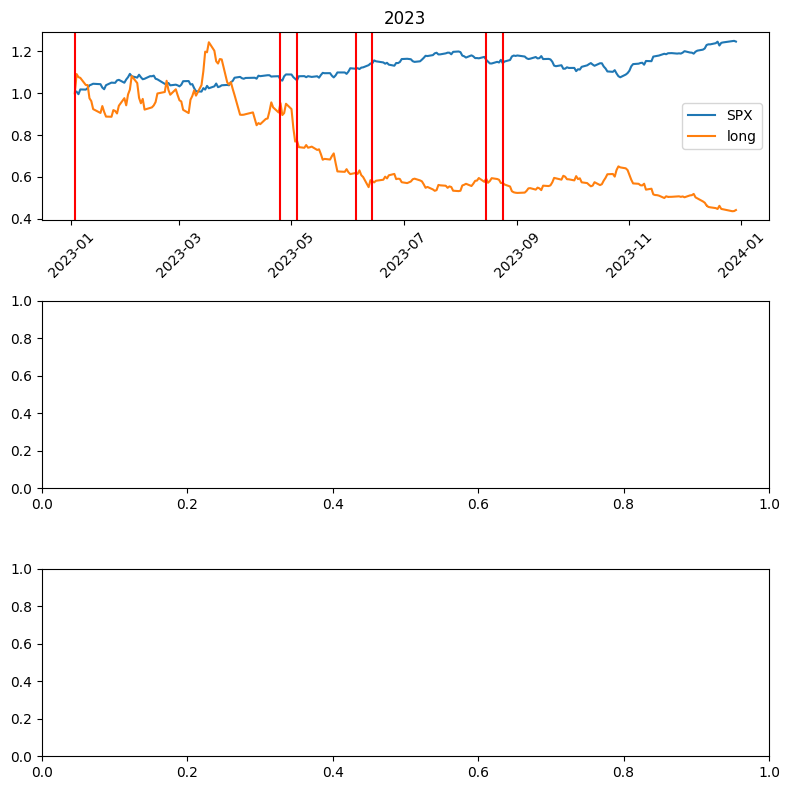

In [15]:

list_da = []
fig, ax = plt.subplots(3, 1, figsize=(8, 8))
graph_iter = 0

'''
params init
'''
trade_list_buy = {}
trade_list_sell = {}
nav_all = pd.Series()
nav_current = 1

nav_all_short = pd.Series()
nav_current_short = 1
short_current_list = []
buy_current_list = []
# monthly: interval=20
interval = 7

# signal for 2021
twse = get_quadrants_v2(start=start+timedelta(days=365*1), end=end+timedelta(days=365*1))
twse.dropna(inplace=True)
print(twse.signal.value_counts())
df_close = get_data_from_yfinance(etfs, start=end, end=end+timedelta(days=365*1))
test_da = df_close[df_close.index >= end].index[::interval]

for index, da in enumerate(test_da):
    signal = twse[twse.index == da].signal[0]
    buy_sell = list_[signal-1]
    # print(buy_sell, signal, da)
    # print(signal, list_)
    buy_cls = etf_list[buy_sell[0]] # buy ETFs
    sell_cls = etf_list[buy_sell[1]] # sell ETFs
    # print(signal, da, buy_cls)
    if index == len(test_da) - 1:
        # print("============", da)
        nav_df = df_close[buy_cls][(df_close.index >= da) & (df_close.index <= da + timedelta(days=30))]
        
        nav_df_short = df_close[sell_cls][(df_close.index >= da) & (df_close.index <= da + timedelta(days=30))]
    else:
        nav_df = df_close[buy_cls][(df_close.index >= da) & (df_close.index <= test_da[index+1])]
        nav_df_short = df_close[sell_cls][(df_close.index >= da) & (df_close.index <= test_da[index+1])]
    nav_df.dropna(axis=1, inplace=True)
    etf_objs = len(nav_df.columns)
    weighting = [1/etf_objs]*etf_objs
    nav_series, nav_current = getNavSeries(nav_df, weighting, nav_current)
    nav_all = pd.concat([nav_all, nav_series], axis=0)

    # nav_df_short.dropna(axis=1, inplace=True)
    # etf_objs_short = len(nav_df_short.columns)
    # weighting_short = [1/etf_objs_short]*etf_objs_short
    # nav_series_short, nav_current_short = getNavSeries(nav_df_short, weighting_short, nav_current_short, short=True)
    # nav_all_short = pd.concat([nav_all_short, nav_series_short], axis=0)
#     # ========================================
    if buy_current_list != buy_cls:
        
        buy_current_list = buy_cls
        trade_list_buy[da] = [signal, buy_cls, sell_cls]
#     # ========================================

# =========sell quad
# nav_all_short = 1/nav_all_short
# nav_s2 = (nav_all + nav_all_short)/2
# ax[1].plot(nav_all_short, label='short')
# ax[0].plot(nav_all_short, label='short')
# ax[graph_iter].plot(nav_s2, label='strat')
a = yf.download("^SPX", start=end, end=end+timedelta(days=365))['Close']
spx = (1+a.pct_change()).cumprod()
ax[0].plot(spx, label='SPX')



ax[0].tick_params(axis='x', rotation=45)
ax[0].plot(nav_all, label='long')
ax[0].set_title(end.strftime("%Y"))
ax[0].legend()
for i in list(trade_list_buy.keys()):
    ax[0].axvline(i, color="r")

plt.tight_layout()

print("=======Buy=======")
print(list_)
trade_list_buy